In [1]:
import datetime
import os
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras import backend as K
#from tensorflow.keras.layers import (
#    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, Input, Dropout, MaxPooling2D, concatenate, BatchNormalization)
import matplotlib.pyplot as plt
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.config.experimental.set_memory_growth(physical_devices[1], True)
plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [4]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [5]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [6]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [7]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [8]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [9]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1
#BATCH_SIZE = 16

In [10]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [11]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

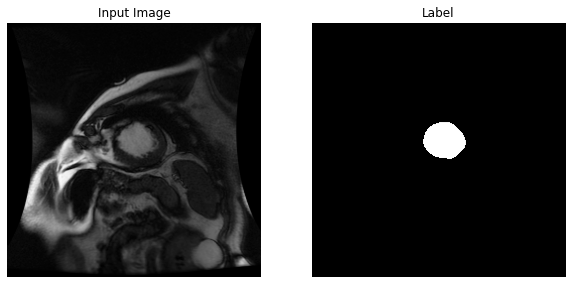

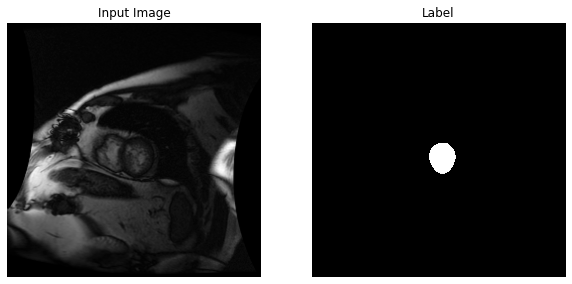

In [12]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

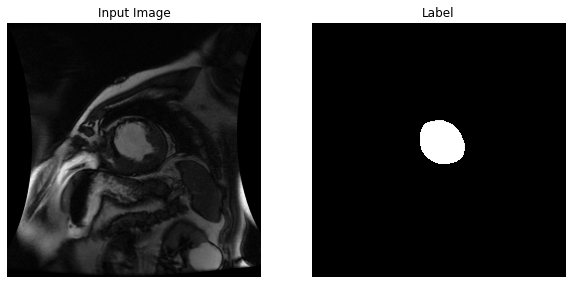

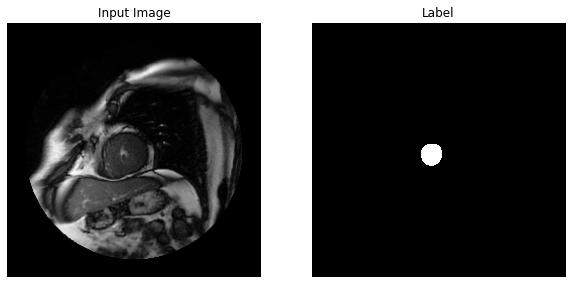

In [13]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [14]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [15]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

In [16]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [18]:
img_size = (256,256)
# Maybe not best to use these since kernel dies more frequently
opt = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [dice_coef,'accuracy']
#metrics = [dice_coef]
#callbacks = [DisplayCallback(), tensorboard_callback]

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2865), started 0:51:41 ago. (Use '!kill 2865' to kill it.)

In [20]:
# SKIP TO MODEL 4
# Run all cells above this point
# plot the model including the sizes of the model
tf.keras.utils.plot_model(cnn_mdl[2], show_shapes=True)

NameError: name 'cnn_mdl' is not defined

In [19]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [25]:
# MODEL 1 -----------------------------------------
nets = 3
cnn_mdl = [0] *nets
f1 = 32
f2 = 64
f3 = 128
f4 = 2
def get_mdl(j):
    inputs = Input(shape=img_size + (1,))
    #x = Conv2D(input_shape=[256, 256, 1],
    x = Conv2D(filters=f1,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1")(inputs)
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)
    if j>0:
        x = Conv2D(filters=f2,
               kernel_size=5,
               strides=2,
               padding="same",
               activation=tf.nn.relu)(x)
        x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)
    if j>1:
        x = Conv2D(filters=f2,
               kernel_size=5,
               strides=2,
               padding="same",
               activation=tf.nn.relu)(x)
        x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)
    if j>2:
        x = Conv2D(filters=f2,
               kernel_size=5,
               strides=2,
               padding="same",
               activation=tf.nn.relu)(x)
        x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)

    x = Conv2D(filters=f3,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu)(x)
    if j>0:
        x = Conv2D(filters=f3,
               kernel_size=3,
               strides=1,
               padding="same",
               activation=tf.nn.relu)(x)
    if j>1:
        x = Conv2D(filters=f4,
               kernel_size=1,
               strides=1,
               padding="same",
               activation=tf.nn.relu)(x)
    if j>2:
        x = Conv2D(filters=f4,
               kernel_size=1,
               strides=1,
               padding="same",
               activation=tf.nn.relu)(x)
    stride = [4, 16, 64]
    conv10 = Conv2DTranspose(filters=2, kernel_size=31, strides=stride[j], padding="same")(x)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[dice_coef,'accuracy'])
    return model

    #model = tf.keras.models.Sequential(get_mdl)
    #tf.keras.backend.clear_session()
for j in range(3):
    cnn_mdl[j] = get_mdl(j)
#model.compile(
#    optimizer='adam',
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#    metrics=['accuracy'])

In [26]:
# From how to chose a cnn arch - deotte

from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))
import tensorflow as tf
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']


# TRAIN NETWORKS
history = [0] * nets
names = ["(C-P)x1","(C-P)x2","(C-P)x3"]
epochs = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
with tf.device('/device:GPU:1'):
    for j in range(nets):
        history[j] = cnn_mdl[j].fit(train_dataset, batch_size=80, epochs = epochs, steps_per_epoch=STEPS_PER_EPOCH,
            validation_data = test_dataset, callbacks=[annealer], verbose=0)
        #print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        #    names[j],epochs,max(history[j].history['accuracy']),max(history[j].history[dice_coef]) ))
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Dice Coef={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']), max(history[j].history['dice_coef']) ))

CNN (C-P)x1: Epochs=20, Train accuracy=0.99388, Dice Coef=0.73598
CNN (C-P)x2: Epochs=20, Train accuracy=0.99872, Dice Coef=0.93404
CNN (C-P)x3: Epochs=20, Train accuracy=0.98641, Dice Coef=0.30781


In [28]:
# print out the summary of the model
cnn_mdl[0].summary()
inputs.shape


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 300)       270300    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 1024, 1024, 2)     576602    
Total params: 849,502
Trainable params: 849,502
Non-trainable params: 0
_________________________________________________________________


NameError: name 'inputs' is not defined

In [95]:
# Maybe delete since compile is part of model build. But Multi-GPU doesn't work so maybe keep.
#from tensorflow.keras.optimizers import *
opt = 'adam'
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#opt = 'sgd'
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()
model.compile(
    optimizer=opt,
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='binary_crossentropy',
    metrics=[dice_coef,'accuracy'])
    #metrics=[dice_coef])

Epoch 1/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9659 - accuracy: 0.9994

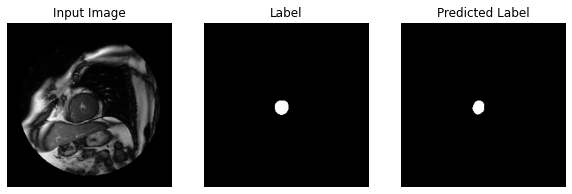


Sample Prediction after epoch 1

234/234 [==============================] - 5s 20ms/step - loss: 0.3138 - dice_coef: 0.9659 - accuracy: 0.9994 - val_loss: 0.3152 - val_dice_coef: 0.8479 - val_accuracy: 0.9979
Epoch 2/30
234/234 [==============================] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

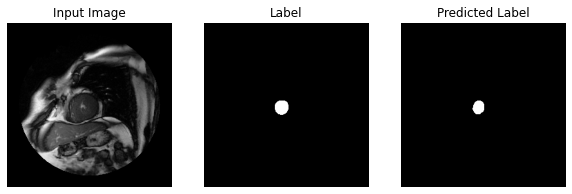


Sample Prediction after epoch 2

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8475 - val_accuracy: 0.9979
Epoch 3/30
234/234 [==============================] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

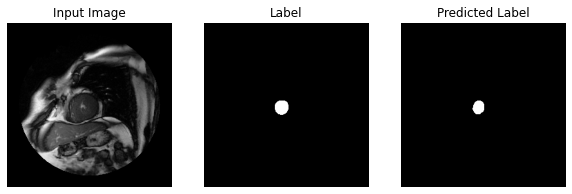


Sample Prediction after epoch 3

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8472 - val_accuracy: 0.9979
Epoch 4/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

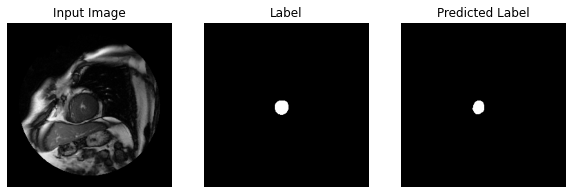


Sample Prediction after epoch 4

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9663 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8471 - val_accuracy: 0.9979
Epoch 5/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9663 - accuracy: 0.9994

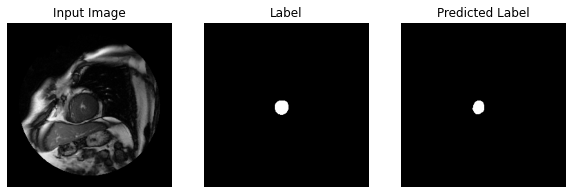


Sample Prediction after epoch 5

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8472 - val_accuracy: 0.9979
Epoch 6/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

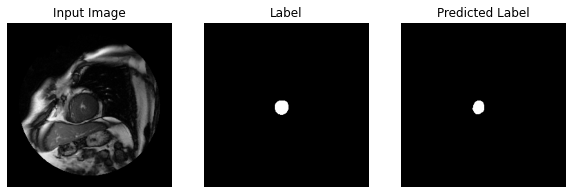


Sample Prediction after epoch 6

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9663 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8466 - val_accuracy: 0.9979
Epoch 7/30
230/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

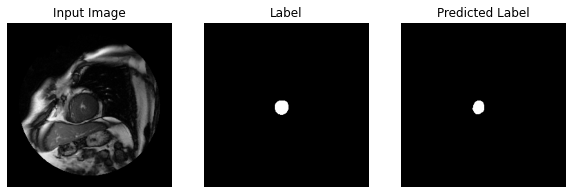


Sample Prediction after epoch 7

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8468 - val_accuracy: 0.9979
Epoch 8/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994

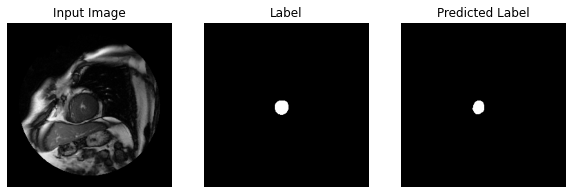


Sample Prediction after epoch 8

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8469 - val_accuracy: 0.9979
Epoch 9/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9661 - accuracy: 0.9994

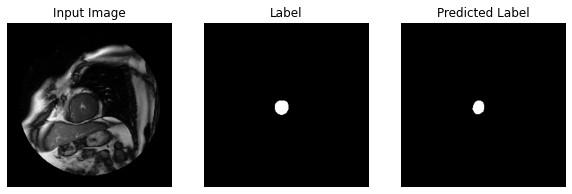


Sample Prediction after epoch 9

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8462 - val_accuracy: 0.9979
Epoch 10/30
230/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9660 - accuracy: 0.9994

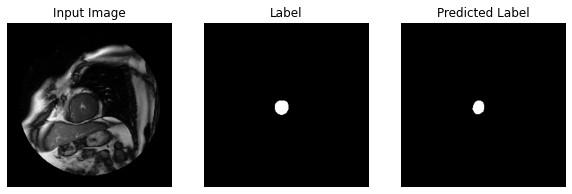


Sample Prediction after epoch 10

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8469 - val_accuracy: 0.9979
Epoch 11/30
234/234 [==============================] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994

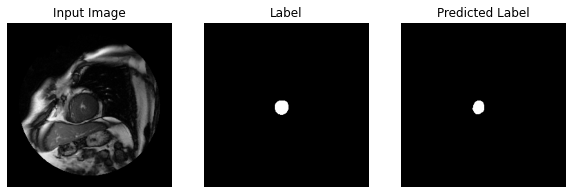


Sample Prediction after epoch 11

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8467 - val_accuracy: 0.9979
Epoch 12/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9994

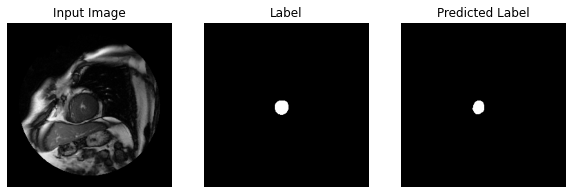


Sample Prediction after epoch 12

234/234 [==============================] - 4s 17ms/step - loss: 0.3138 - dice_coef: 0.9665 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 13/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9663 - accuracy: 0.9994

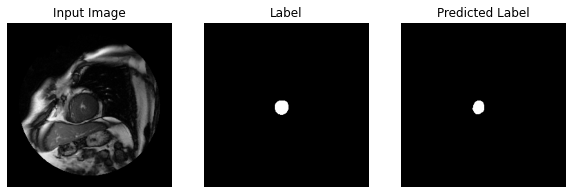


Sample Prediction after epoch 13

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9665 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8469 - val_accuracy: 0.9979
Epoch 14/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9662 - accuracy: 0.9994

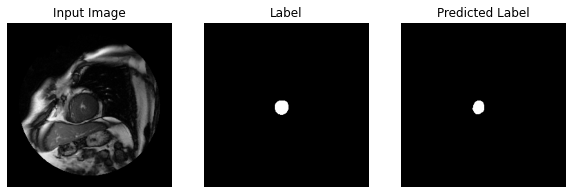


Sample Prediction after epoch 14

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9665 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 15/30
234/234 [==============================] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994

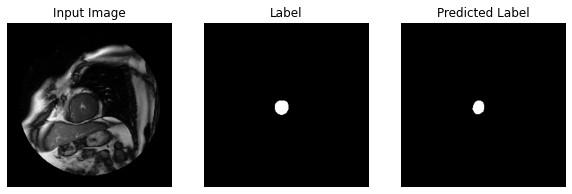


Sample Prediction after epoch 15

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8463 - val_accuracy: 0.9979
Epoch 16/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9669 - accuracy: 0.9994

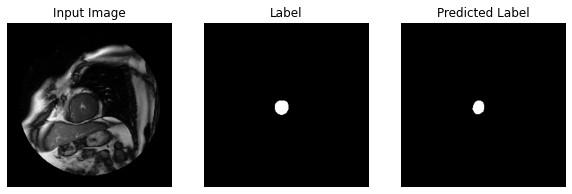


Sample Prediction after epoch 16

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8463 - val_accuracy: 0.9979
Epoch 17/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9665 - accuracy: 0.9995

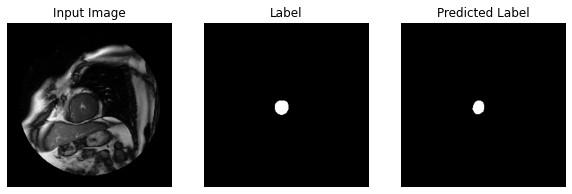


Sample Prediction after epoch 17

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8461 - val_accuracy: 0.9979
Epoch 18/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9663 - accuracy: 0.9994

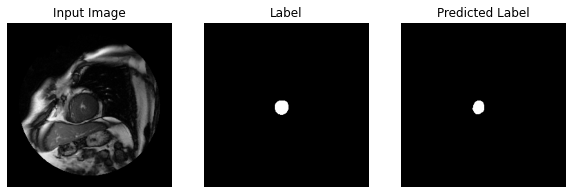


Sample Prediction after epoch 18

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 19/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9665 - accuracy: 0.9995

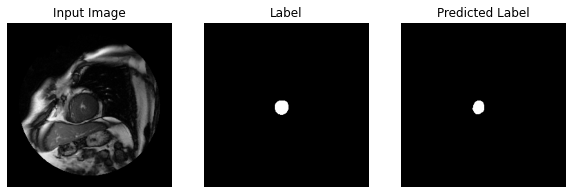


Sample Prediction after epoch 19

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 20/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9994

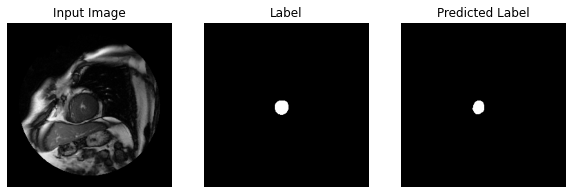


Sample Prediction after epoch 20

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 21/30
234/234 [==============================] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9995

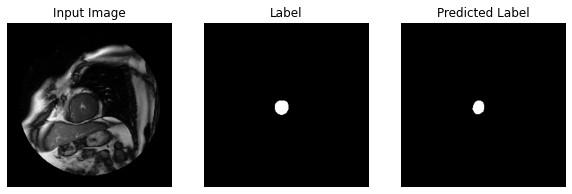


Sample Prediction after epoch 21

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 22/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9995

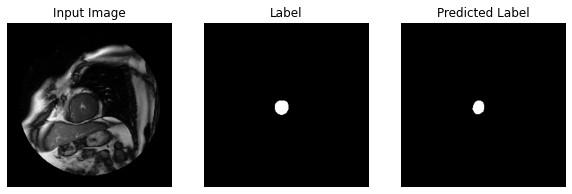


Sample Prediction after epoch 22

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 23/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995

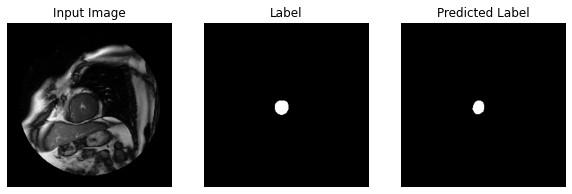


Sample Prediction after epoch 23

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 24/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995

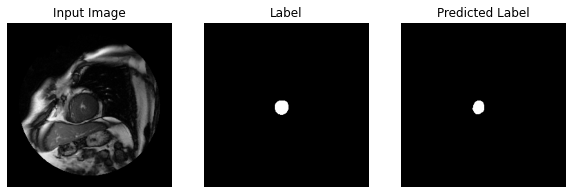


Sample Prediction after epoch 24

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 25/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995

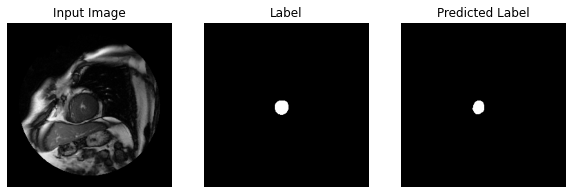


Sample Prediction after epoch 25

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8466 - val_accuracy: 0.9979
Epoch 26/30
231/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9664 - accuracy: 0.9995

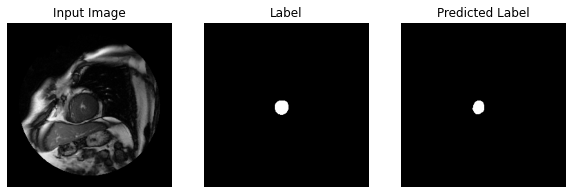


Sample Prediction after epoch 26

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8465 - val_accuracy: 0.9979
Epoch 27/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9995

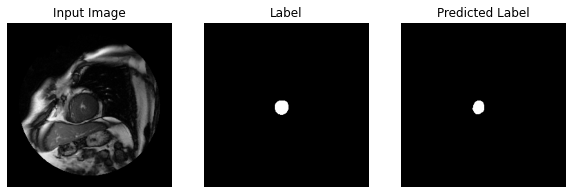


Sample Prediction after epoch 27

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 28/30
233/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995

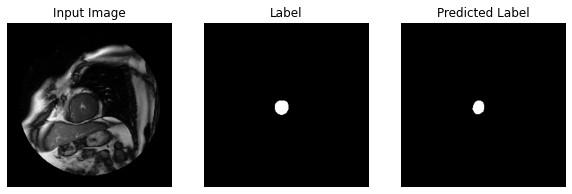


Sample Prediction after epoch 28

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8464 - val_accuracy: 0.9979
Epoch 29/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9666 - accuracy: 0.9995

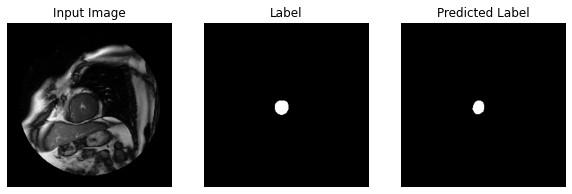


Sample Prediction after epoch 29

234/234 [==============================] - 4s 16ms/step - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8462 - val_accuracy: 0.9979
Epoch 30/30
232/234 [============================>.] - ETA: 0s - loss: 0.3138 - dice_coef: 0.9667 - accuracy: 0.9995

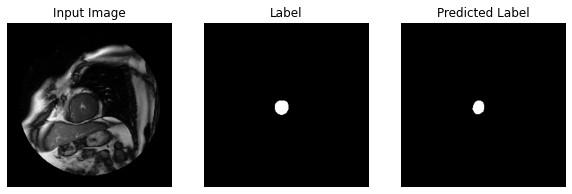


Sample Prediction after epoch 30

234/234 [==============================] - 4s 17ms/step - loss: 0.3138 - dice_coef: 0.9668 - accuracy: 0.9995 - val_loss: 0.3153 - val_dice_coef: 0.8466 - val_accuracy: 0.9979


In [96]:
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()
# setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

with tf.device('/device:GPU:1'):
    model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_data=test_dataset,
                              callbacks=[DisplayCallback(),tensorboard_callback])

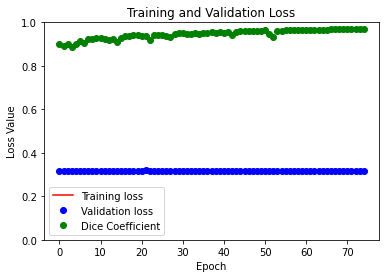

In [86]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

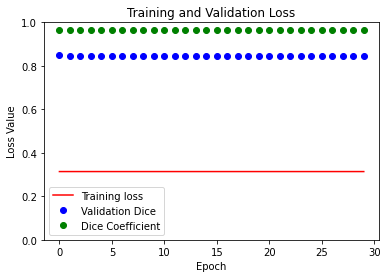

In [97]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']
val_dice = model_history.history['val_dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_dice, 'bo', label='Validation Dice')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()